In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from alstm import ALSTMModel
from nltk.corpus import stopwords

In [ ]:
# Step 1: Data Preprocessing
from text_preprocessor import TextPreprocessor

In [893]:
# Step 2: Create PyTorch Dataset
class TextClassificationDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

In [894]:
# Step 3: Create collate function for batching
def collate_fn(batch):
    """Collate function to pad sequences in a batch"""
    texts, labels = zip(*batch)
    
    # Pad sequences to the length of the longest sequence in the batch
    padded_texts = pad_sequence([text for text in texts], batch_first=True, padding_value=0)
    
    return padded_texts.to(torch.int64), torch.tensor(labels)

In [895]:
# Step 5: Training Function
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=5, best_valid_loss=float('inf')):
    # Initialize best validation loss
    best_valid_loss = best_valid_loss
    
    # Training history
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_train_loss = 0
        epoch_train_acc = 0
        train_samples = 0
        
        for batch_idx, (texts, labels) in enumerate(train_loader):
            texts, labels = texts.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            # print('token ids:', texts)
            predictions = model(texts)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Calculate accuracy
            predictions_class = torch.argmax(predictions, dim=1)
            correct = (predictions_class == labels).float().sum()
            
            # Update metrics
            epoch_train_loss += loss.item() * len(labels)
            epoch_train_acc += correct.item()
            train_samples += len(labels)
            
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, ' 
                      f'Loss: {loss.item():.4f}, Acc: {correct.item()/len(labels):.4f}')
        
        # Calculate average loss and accuracy for the epoch
        epoch_train_loss /= train_samples
        epoch_train_acc /= train_samples
        
        # Validation
        model.eval()
        epoch_valid_loss = 0
        epoch_valid_acc = 0
        valid_samples = 0
        
        with torch.no_grad():
            for texts, labels in valid_loader:
                texts, labels = texts.to(device), labels.to(device)
                
                # Forward pass
                predictions = model(texts)
                
                # Calculate loss
                loss = criterion(predictions, labels)
                
                # Calculate accuracy
                predictions_class = torch.argmax(predictions, dim=1)
                correct = (predictions_class == labels).float().sum()
                
                # Update metrics
                epoch_valid_loss += loss.item() * len(labels)
                epoch_valid_acc += correct.item()
                valid_samples += len(labels)
        
        # Calculate average validation loss and accuracy
        epoch_valid_loss /= valid_samples
        epoch_valid_acc /= valid_samples
        
        # Save the best model
        if epoch_valid_loss < best_valid_loss:
            best_valid_loss = epoch_valid_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'Model saved with validation loss: {best_valid_loss:.4f}')
        
        # Update history
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        train_accs.append(epoch_train_acc)
        valid_accs.append(epoch_valid_acc)
        
        # Print epoch statistics
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
        print(f'Valid Loss: {epoch_valid_loss:.4f}, Valid Acc: {epoch_valid_acc:.4f}')
        print('-' * 60)
    
    return {
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_accs': train_accs,
        'valid_accs': valid_accs
    }

In [896]:
# Step 6: Evaluation Function
def evaluate_model(model, test_loader, criterion, device, label_names=None):
    model.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            
            # Forward pass
            predictions = model(texts)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            predictions_class = torch.argmax(predictions, dim=1)
            correct = (predictions_class == labels).float().sum()
            
            # Collect predictions and labels for classification report
            all_predictions.extend(predictions_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Update metrics
            test_loss += loss.item() * len(labels)
            test_acc += correct.item()
            test_samples += len(labels)
    
    # Calculate average test loss and accuracy
    test_loss /= test_samples
    test_acc /= test_samples
    
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    # Print classification report
    if label_names is not None:
        print('\nClassification Report:')
        print(classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0))
    else:
        print('\nClassification Report:')
        print(classification_report(all_labels, all_predictions))
    
    return test_loss, test_acc

In [897]:
def read_dataset(path: str, google_drive=False) -> pd.DataFrame:
  if google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv(f'/content/drive/{path}')
    return df
  else:
    df = pd.read_csv(path)
    return df

In [898]:
train_df = read_dataset('../dataset/trec_train.csv')
train_df = train_df.dropna()
test_df = read_dataset('../dataset/trec_test.csv')
test_df = test_df.dropna()

# drop all abbreviation
drop_abbreviation=True
if drop_abbreviation:
    train_df = train_df[train_df['coarse_label'] != 0]
    train_df['coarse_label'] = train_df['coarse_label'].apply(lambda x: x-1)
    test_df = test_df[test_df['coarse_label'] != 0]
    test_df['coarse_label'] = test_df['coarse_label'].apply(lambda x: x-1)
    label_names = ["ENTY", "DESC", "HUM", "LOC", "NUM"]
else:
    label_names = ["ABBR", "ENTY", "DESC", "HUM", "LOC", "NUM"]

train_texts = train_df['text'].values
test_texts = test_df['text'].values

train_labels = train_df['coarse_label'].values
test_labels = test_df['coarse_label'].values

In [899]:
X_test = test_texts
y_test = test_labels

# Further split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

In [900]:
import collections
train_labels_counter = collections.Counter(train_labels)
train_labels_counter

Counter({0: 1250, 2: 1223, 1: 1162, 4: 896, 3: 835})

In [901]:
y_train_counter = collections.Counter(y_train)

y_val_counter = collections.Counter(y_val)
# y_train_counter, y_val_counter
y_train_counter[1]/len(y_train), train_labels_counter[1]/len(train_labels)

(0.21644920782851818, 0.21654863958255685)

In [902]:
# Preprocess text data
# CONFIG
USE_STOPWORDS=False
stop = set(stopwords.words('english'))
preprocessor = TextPreprocessor(stopwords=stop, max_vocab_size=10000, max_seq_length=50)
trec_vocab = preprocessor.get_vocab_from_texts([*X_test, *X_val, *X_train], use_stopwords=USE_STOPWORDS)

preprocessor.download_model(filter_from_vocab=trec_vocab)
# preprocessor.fit([*X_train, *X_val, *X_test])
print(f'Vocabulary Size: {preprocessor.vocab_size}')

Vocabulary Size: 8898


In [903]:
if preprocessor.embedding_matrix is not None:
    print(preprocessor.embedding_matrix.shape)

(8898, 300)


In [904]:
# Transform texts to sequences
X_train_seq = preprocessor.transform(X_train, use_stopwords=USE_STOPWORDS)
X_val_seq = preprocessor.transform(X_val, use_stopwords=USE_STOPWORDS)
X_test_seq = preprocessor.transform(X_test, use_stopwords=USE_STOPWORDS)

# Implement Stratified K-Fold

In [905]:
def save_to_excel(
        train_acc,
        test_acc,
        train_loss,
        test_loss,
        drop_rate,
        vocab_size,
        n_heads,
        embedding_trainable,
        optimizer,
        optimizer_lr,
        weight_decay,
        cv_fold,
        epochs,
        use_stopwords,
        drop_abbreviation,
        notes: str,
        file='alstm_model.csv',
    ):
    columns = {
        'no': str(0),
        'train_acc': str(train_acc),
        'test_acc': str(test_acc),
        'train_loss': str(train_loss),
        'test_loss': str(test_loss),
        'drop_rate': str(drop_rate),
        'vocab_size': str(vocab_size),
        'n_heads': str(n_heads),
        'embedding_trainable': str(embedding_trainable),
        'optimizer': optimizer,
        'optimizer_lr': str(optimizer_lr),
        'weight_decay': str(weight_decay),
        'cv_fold': str(cv_fold),
        'epochs': str(epochs),
        'use_stopwords': str(use_stopwords),
        'drop_abbreviation': str(drop_abbreviation),
        'notes': notes,
    }

    # add double quote in notes if contain comma
    if notes.__contains__(","):
        columns['notes'] = f'"{notes}"'

    try:
        df = pd.read_csv('alstm_model.csv')
        last_index = df.shape[0]+1
        columns['no'] = str(last_index)
        
        text = ''
        text += f'\n{",".join(columns.values())}'

        with open(file, 'a') as f:
            f.write(text)
            f.close()

    # file is not yet created
    except (FileNotFoundError, pd.errors.EmptyDataError):
        columns['no'] = '1'
        text = ','.join(columns.keys())
        print(columns.values())
        text += f'\n{",".join(columns.values())}'
        # create new file
        with open(file, 'w') as f:
            f.write(text)
            f.close()

    finally:
        print('model logged')

In [906]:
def create_model(cfg, preprocessor, copy_embedding=True) -> ALSTMModel:
    model = ALSTMModel(cfg)
    if copy_embedding:
        if preprocessor.embedding_matrix is not None:
            print('copying embedding matrix')
            model.embedding.weight.data.copy_(torch.from_numpy(preprocessor.embedding_matrix))
            # make the embedding is not trainable
            model.embedding.weight.requires_grad = False
    return model

In [907]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from copy import deepcopy as dc

def cross_validate(
        # model,
        cfg,
        preprocessor,
        train_dataset,
        test_dataset,
        targets,
        criterion,
        # optimizer,
        learning_rate,
        weight_decay,
        device,
        collate_fn,
        fold=5,
        batch_size=32,
        num_epochs=5,
        debug=False
        ):
    
    history = {}
    best_valid_loss = float('inf')
    best_model = None

    skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)

    print(f'Total fold: {fold}')
    
    history['train'] = []

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        collate_fn=collate_fn)

    for fold, (train_idx, val_idx) in enumerate(skf.split(train_dataset, targets)):
        print(f"Fold: {fold+1}:")
        print(f"Train class distribution: {sum(targets[i] for i in train_idx)}")
        print(f"Validation class distribution: {sum(targets[i] for i in val_idx)}")

        # create model
        model = create_model(cfg, preprocessor)
        model.to(device)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        optimizer_name = type(optimizer).__name__

        # create pytorch subsets
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        train_loader = DataLoader(
            train_subset,
            batch_size=batch_size,
            drop_last=True,
            shuffle=True,
            collate_fn=collate_fn)
        val_loader = DataLoader(
            val_subset,
            batch_size=batch_size,
            collate_fn=collate_fn)
        
        new_fold = train_model(
            model=model,
            train_loader=train_loader,
            valid_loader=val_loader, 
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            best_valid_loss=best_valid_loss
        )

        history['train'].append(new_fold)

        # update best valid loss
        fold_best_valid_loss = min(new_fold['valid_losses'])
        if fold_best_valid_loss < best_valid_loss:
            best_valid_loss = fold_best_valid_loss
            best_model = dc(model)
            print(f'New model saved from fold {fold+1}\n')
        
        del model
        del optimizer
            
    best_model_test_loss, best_model_test_acc = evaluate_model(
        model=best_model,
        test_loader=test_loader,
        criterion=criterion,
        device=device,
        label_names=label_names
    )
    print(f"Final Test Accuracy (best model): {best_model_test_acc:.4f}")

    save_to_excel(
        drop_rate=cfg['drop_rate'],
        test_acc=f'{best_model_test_acc:.4f}',
        test_loss=f'{best_model_test_loss:.4f}',
        vocab_size=preprocessor.vocab_size,
        n_heads=cfg['n_heads'],
        embedding_trainable=best_model.embedding.weight.requires_grad,
        # optimizer=type(optimizer).__name__,
        optimizer=optimizer_name,
        optimizer_lr=learning_rate,
        weight_decay=weight_decay,
        cv_fold=fold,
        epochs=num_epochs,
        use_stopwords=USE_STOPWORDS,
        notes='change feed forward linear into times 2'
    )
    
    return history, best_model

In [908]:
labels = len(label_names)
labels_total = train_df['coarse_label'].value_counts().sort_index().values
# imbalance dataset
targets = []
# targets += [[index] * labels_total[index] for index in range(labels)]
for i in range(labels):
    targets += [i] * labels_total[i]

# Create datasets
cross_dataset = TextClassificationDataset(preprocessor.transform(train_texts, use_stopwords=USE_STOPWORDS), train_labels)
train_dataset = TextClassificationDataset(X_train_seq, y_train)
val_dataset = TextClassificationDataset(X_val_seq, y_val)
test_dataset = TextClassificationDataset(X_test_seq, y_test)

batch_size=50
num_workers=0

torch.manual_seed(42)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    collate_fn=collate_fn)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=collate_fn)

In [909]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
cfg = {
    'drop_rate': 0.0,
    'output': len(set(train_labels)),
    'bidirectional': True,
    'vocab_size': preprocessor.vocab_size,
    'context_length': 100,
    'emb_dim': 300,
    'hidden_size': 150,
    'qkv_bias': False,
    'n_heads': 1,
    'device': device,
    'lstm_layers': 1,
}
model = ALSTMModel(cfg)

if preprocessor.embedding_matrix is not None:
    print('copying embedding matrix')
    model.embedding.weight.data.copy_(torch.from_numpy(preprocessor.embedding_matrix))
    # make the embedding is not trainable
    model.embedding.weight.requires_grad = False


# Move model to device
model = model.to(device)

# Print model summary
print(model)

# Loss function and optimizer
learning_rate=0.001
weight_decay=0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

Using device: mps
copying embedding matrix
ALSTMModel(
  (embedding): Embedding(8898, 300, padding_idx=0)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (lstm): LSTMBlock(
    (lstm): LSTM(
      (layers_forward): ModuleList(
        (0): LSTMCell(
          (W_x): Linear(in_features=300, out_features=600, bias=True)
          (W_h): Linear(in_features=150, out_features=600, bias=True)
        )
      )
      (dropout_forward): ModuleList()
      (layers_backward): ModuleList(
        (0): LSTMCell(
          (W_x): Linear(in_features=300, out_features=600, bias=True)
          (W_h): Linear(in_features=150, out_features=600, bias=True)
        )
      )
      (dropout_backward): ModuleList()
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (attn_forward): MultiHeadAttention(
    (W_query): Linear(in_features=150, out_features=150, bias=False)
    (W_key): Linear(in_features=150, out_features=150, bias=False)
    (W_value): Linear(in_features=150, out_features=150, bias=False)
 

In [910]:
cv_fold=10
EPOCHS = 60

# Train the model
# history, best_model = cross_validate(
#     cfg=cfg,
#     preprocessor=preprocessor,
#     fold=cv_fold,
#     train_dataset=cross_dataset,
#     test_dataset=test_dataset,
#     targets=targets,
#     criterion=criterion,
#     learning_rate=learning_rate,
#     weight_decay=weight_decay,
#     device=device,
#     batch_size=64,
#     collate_fn=collate_fn,
#     num_epochs=EPOCHS,
# )

history = train_model(
    model=model, 
    train_loader=train_loader, 
    valid_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    device=device, 
    num_epochs=EPOCHS
)

Epoch 1/60, Batch 10/85, Loss: 1.6246, Acc: 0.2200
Epoch 1/60, Batch 20/85, Loss: 1.5442, Acc: 0.2800


KeyboardInterrupt: 

In [ ]:
# Load best model
best_model = ALSTMModel(cfg)
best_model.load_state_dict(torch.load('best_model.pt', weights_only=True))

# Evaluate on test set
test_loss, test_acc = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    label_names=label_names
)

best_model_test_loss, best_model_test_acc = evaluate_model(
    model=best_model,
    test_loader=test_loader,
    criterion=criterion,
    device=device,
    label_names=label_names
)

print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Accuracy (best model): {best_model_test_acc:.4f}")

Test Loss: 0.6768, Test Acc: 0.9022

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.85      0.76      0.80        94
        DESC       0.90      0.93      0.91       138
         HUM       0.88      0.97      0.92        65
         LOC       0.93      0.94      0.93        81
         NUM       0.95      0.93      0.94       113

    accuracy                           0.90       491
   macro avg       0.90      0.90      0.90       491
weighted avg       0.90      0.90      0.90       491

Test Loss: 0.3532, Test Acc: 0.9022

Classification Report:
              precision    recall  f1-score   support

        ENTY       0.88      0.68      0.77        94
        DESC       0.88      0.96      0.92       138
         HUM       0.85      0.97      0.91        65
         LOC       0.93      0.93      0.93        81
         NUM       0.96      0.96      0.96       113

    accuracy                           0.90       491
   macro av

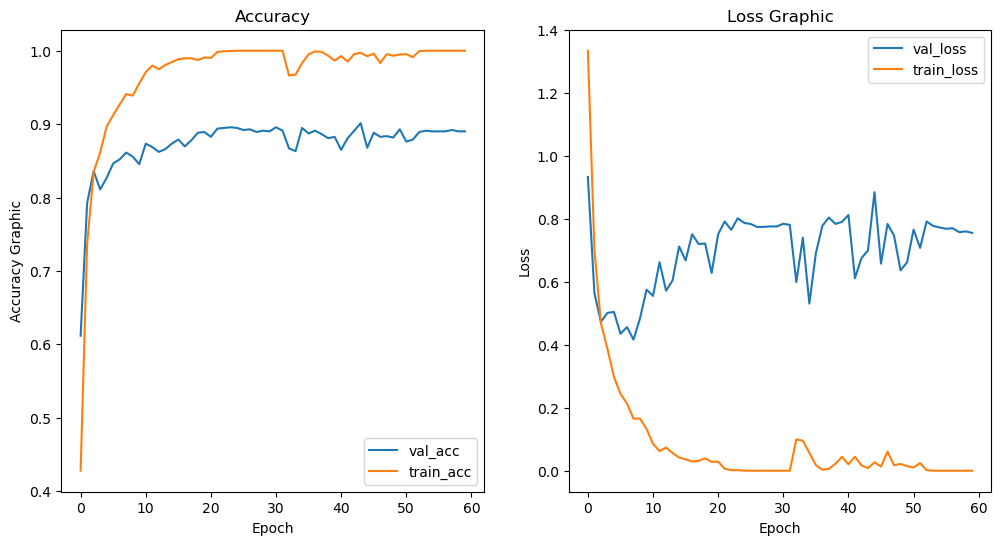

In [ ]:
import matplotlib.pyplot as plt

all_train_accs = history['train_accs']
all_valid_accs = history['valid_accs']

all_train_losses = history['train_losses']
all_valid_losses = history['valid_losses']


plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(range(len(all_valid_accs)), all_valid_accs, label='val_acc')
plt.plot(range(len(all_train_accs)), all_train_accs, label='train_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Graphic')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(all_valid_losses)), all_valid_losses, label='val_loss')
plt.plot(range(len(all_train_losses)), all_train_losses, label='train_loss')
plt.title('Loss Graphic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
def predict_question(question, model, preprocessor: TextPreprocessor):
    question = preprocessor.transform([question])
    batched = torch.tensor(question)
    with torch.no_grad():
        model.eval()
        logits = model(batched)
        # logits
        output = torch.softmax(logits[0], dim=-1)
    return output

questions = [
    'What river in the US is known as the Big Muddy ?',
    'What year did the NFL go on strike ?',
    'What is bio-diversity ?',
    'Who is america current president ?',
    'Where is the biggest mountain located ?',
    'What is BPUPKI stand for ?',
    'Why do female lion went hunting ?'
]

for index, question in enumerate(questions):
    output = predict_question(question, best_model, preprocessor)
    confidence = torch.max(output)
    max = torch.argmax(output)
    

    print(f'{index+1}. Question: {question}')
    print(f'   Predicted Class: {label_names[max]} ({max})\n   Confidence: {confidence}')

1. Question: What river in the US is known as the Big Muddy ?
   Predicted Class: LOC (3)
   Confidence: 0.995149552822113
2. Question: What year did the NFL go on strike ?
   Predicted Class: NUM (4)
   Confidence: 0.9756145477294922
3. Question: What is bio-diversity ?
   Predicted Class: ENTY (0)
   Confidence: 0.955470085144043
4. Question: Who is america current president ?
   Predicted Class: HUM (2)
   Confidence: 0.999871015548706
5. Question: Where is the biggest mountain located ?
   Predicted Class: LOC (3)
   Confidence: 0.9998316764831543
6. Question: What is BPUPKI stand for ?
   Predicted Class: DESC (1)
   Confidence: 0.8054697513580322
7. Question: Why do female lion went hunting ?
   Predicted Class: HUM (2)
   Confidence: 0.9925064444541931


# Excel

In [ ]:
save_to_excel(
    drop_rate=cfg['drop_rate'],
    train_acc=f'{all_train_accs[-1]:.4f}',
    test_acc=f'{best_model_test_acc:.4f}' if best_model_test_acc > test_acc else f'{test_acc:.4f}',
    train_loss=f'{all_train_losses[-1]:.4f}',
    test_loss=f'{best_model_test_loss:.4f}' if best_model_test_acc > test_acc else f'{test_loss:.4f}',
    vocab_size=preprocessor.vocab_size,
    n_heads=cfg['n_heads'],
    embedding_trainable=model.embedding.weight.requires_grad,
    optimizer=type(optimizer).__name__,
    optimizer_lr=learning_rate,
    weight_decay=weight_decay,
    cv_fold=cv_fold,
    epochs=EPOCHS,
    use_stopwords=USE_STOPWORDS,
    drop_abbreviation=drop_abbreviation,
    notes='disable norm1, dropout. use ff*2. split attention layer for forward and backward LSTM output'
)

model logged
